In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.optimize import curve_fit

In [2]:
class DataSlide:
	def __init__(self, keys, vals):
		self.data = dict(zip(keys, vals))

	def get(self, key):
		if self.data[key].ndim == 1:
			return self.data[key][0]
		else:
			return self.data[key][:,0]
	
	def get_err(self, key):
		if self.data[key].ndim == 1:
			raise KeyError("Data not found")
		else:
			return self.data[key][:,1]

	def get_nruns(self, key):
		if self.data[key].ndim == 1:
			raise KeyError("Data not found")
		else:
			return self.data[key][:,2]

class DataFrame:
	def __init__(self):
		self.params = {}
		self.slides = []
	
	def __add__(self, other):
		new = DataFrame()
		new.params = {**self.params, **other.params}

		for slide in self.slides:
			new.add_dataslide(slide)
		for slide in other.slides:
			new.add_dataslide(slide)

		return new

	def add_dataslide(self, slide):
		self.slides.append(slide)

	def get_property_with_id(self, key, id):
		return self.slides[id][key]

	def get_param(self, key):
		return self.params[key]

	def get(self, key):
		val = []
		for slide in self.slides:
			val.append(slide.get(key))
		return np.array(val)
	
	def get_err(self, key):
		val = []
		for slide in self.slides:
			val.append(slide.get_err(key))
		return np.array(val)

	def get_nruns(self, key):
		val = []
		for slide in self.slides:
			val.append(slide.get_nruns(key))
		return np.array(val)
	
	def query_key(self, key, val):
		new_df = DataFrame()
		for slide in self.slides:
			if np.isclose(slide[key], val):
				new_df.add_dataslide(slide)
		return new_df

def parse_datafield(s):
	if list(s.keys())[0] == 'Data':
		sample = s[list(s.keys())[0]]
		return np.array(sample)
	else:
		return np.array([s[list(s.keys())[0]]])

def load_data(filename):
	data = DataFrame()
	with open(filename, 'r') as f:
		json_contents = json.load(f)
		for param_key in json_contents['params']:
			data.params[param_key] = parse_datafield(json_contents['params'][param_key])[0]
		for slide in json_contents['slides']:
			keys = list(slide['data'].keys())
			vals = [parse_datafield(slide['data'][key]) for key in keys]
				
			data.add_dataslide(DataSlide(keys, vals))
	
	return data

In [3]:
def plot_run(data: DataFrame, run_id: int, average_interval: int = 1, ax = None):
	if ax is None:
		ax = plt.gca()

	entropy = data.get_property_with_id("entropy", run_id)
	if average_interval != 1:
		times = []
		entropy_avg = []
		for i in range(len(entropy)//average_interval):
			times.append(i*average_interval)
			entropy_avg.append(np.mean(entropy[i*average_interval:(i+1)*average_interval]))
	else:
		entropy_avg = entropy

	ax.plot(entropy_avg)
	ax.set_xlabel(r'$t$', fontsize=16)
	ax.set_ylabel(r'$S_A^2$', fontsize=16)

def plot_all_data(data: DataFrame, ax = None):
	if ax is None:
		ax = plt.gca()

	unique_p = sorted(list(set(data.get('mzr_prob'))))
	unique_LA = sorted(list(set(data.get('partition_size'))))
	entropy = np.zeros((len(unique_p), len(unique_LA)))
	entropy_err = np.zeros((len(unique_p), len(unique_LA)))
	for slide in data.slides:
		i = unique_p.index(slide.get('mzr_prob'))
		j = unique_LA.index(slide.get('partition_size'))

		entropy[i][j] = slide.get('entropy')
		entropy_err[i][j] = slide.get_err('entropy')

	colors = ['C0', 'orange', 'yellow', 'purple', 'green', 'black', 'magenta', 'cyan']
	for n,p in enumerate(unique_p):
		ax.errorbar(unique_LA, entropy[n], yerr=entropy_err[n], linewidth=1.5, marker='*', color=colors[n-1 if 0 in unique_p else n], label=f'p = {p}')

	ax.legend(fontsize=16)
	ax.set_xlabel(r'$L_A$', fontsize=16)
	ax.set_ylabel(r'$\overline{S_A^{(2)}}$', fontsize=16)

def linear(x, a, b):
	return x*a + b
	
def combine_dist(s1, s2):
	(mean1, std1, N1) = s1
	(mean2, std2, N2) = s2

	N3 = N1 + N2
	mean3 = (N1*mean1 + N2*mean2)/N3
	std3 = np.sqrt((N1*(std1**2 + (mean1 - mean3)**2) + N2*(std2**2 + (mean2 - mean3)**2))/N3)

	return (mean3, std3, N3)

def combine_many_dists(dists):
	dists = list(dists)
	dist = dists[0]
	for d in dists[1:]:
		dist = combine_dist(d, dist)
	return dist


def average_data(df: DataFrame):
	entropy_samples = np.array([slide.get('entropy') for slide in df.slides]).T
	entropy_err_samples = np.array([slide.get_err('entropy') for slide in df.slides]).T
	nrun_samples = np.array([slide.get_nruns('entropy') for slide in df.slides]).T

	num_times = len(entropy_samples)
	measurement_freq = df.get_param('measurement_freq')
	equilibration_steps = df.get_param('equilibration_steps')

	S = np.zeros(num_times)
	dS = np.zeros(num_times)
	N = np.zeros(num_times)

	for i in range(num_times):
		(S[i], dS[i], N[i]) = combine_many_dists(zip(entropy_samples[i], entropy_err_samples[i], nrun_samples[i]))
	
	t = np.array([equilibration_steps + (i+1)*measurement_freq for i in range(num_times)])

	return S, dS, N, t


In [4]:
ee_string = r'$\overline{S_A^{(2)}}$'
ee_var_string = r'Var[$S_A^{(2)}$]'


def logx(partition_size, system_size):
	return np.log(np.sin(np.pi*partition_size/system_size)*system_size/np.pi)


# Used by fig4 and fig5
def combine_slides(data: DataFrame):
	data.slides = sorted(data.slides, key=lambda slide: slide.get('partition_size'))
	num_slides = len(data.slides)

	# Horrible; cleanup
	data_new = DataFrame()
	data_new.params = data.params
	for i in range(0, num_slides, 2):
		ds = DataSlide(data.slides[i].data.keys(), data.slides[i].data.values())
		ds.data['entropy'] = np.array([combine_dist(data.slides[i].data['entropy'][0], data.slides[i+1].data['entropy'][0])])
		data_new.add_dataslide(ds)
	
	data = data_new

	partition_sizes = np.array([slide.get('partition_size') for slide in data.slides])
	entropy = data.get('entropy').flatten()
	entropy_err = data.get_err('entropy').flatten()

	inds = np.argsort(partition_sizes)
	partition_sizes, entropy, entropy_err = partition_sizes[inds], entropy[inds], entropy_err[inds]

	return partition_sizes, entropy, entropy_err

def truncate_data(x, S, dS):
	max_ind = np.argmax(x)

	return x[:max_ind], S[:max_ind], dS[:max_ind]

suffix2 = "_rc_2"
suffix4 = "_rc_4"


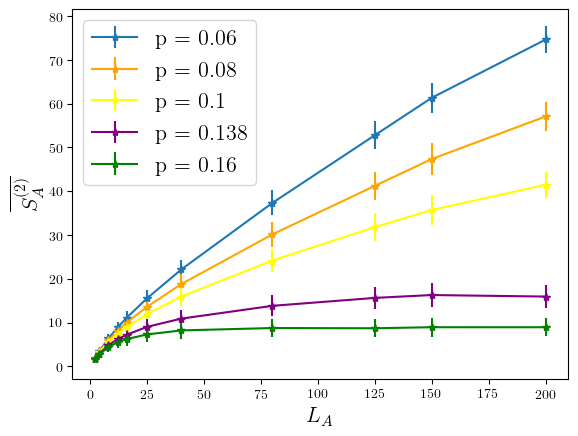

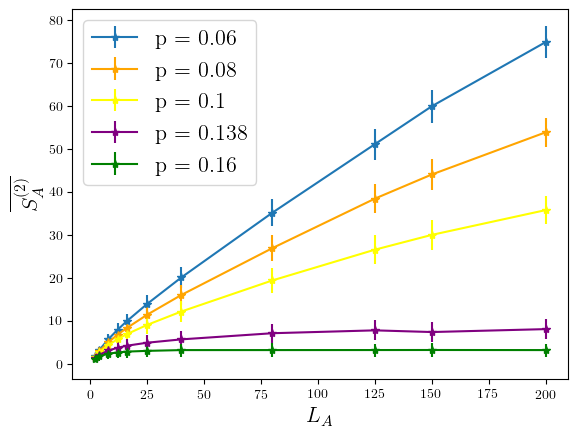

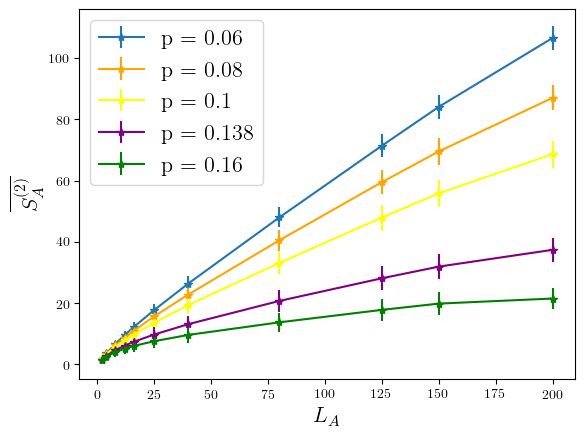

In [6]:
def fig1(filename):
	data = load_data(filename)
	plot_all_data(data)
	plt.show()



fig1("data/base.json")
fig1("data/base" + suffix2 + ".json")
fig1("data/base" + suffix4 + ".json")

200: [ 4.36908453 -4.80170653]
400: [ 4.31171873 -4.75563046]
800 logt: [2.5661004593685584, -1.8155531559797198]


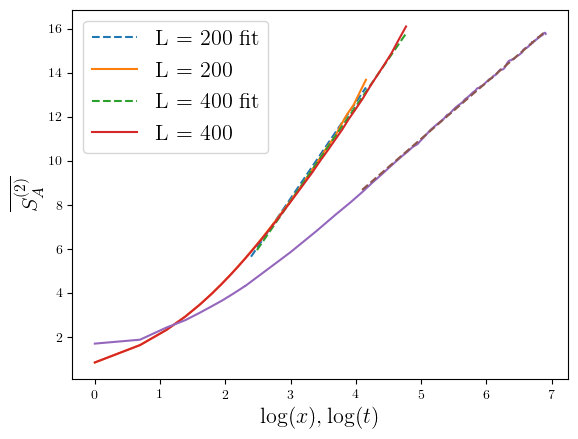

200: [ 1.75577855 -0.71196562]
400: [ 1.7445328  -0.68024321]
800 logt: [1.57322217316919, -1.5490679015007227]


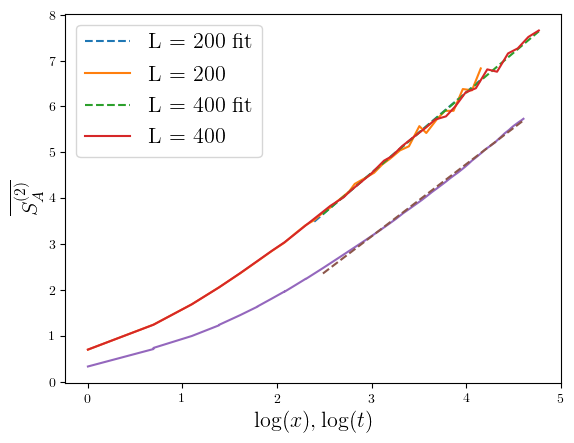

200: [  8.06559939 -15.12328023]
400: [  9.88445844 -21.2494088 ]
800 logt: [14.440791452493466, -37.86133843050834]


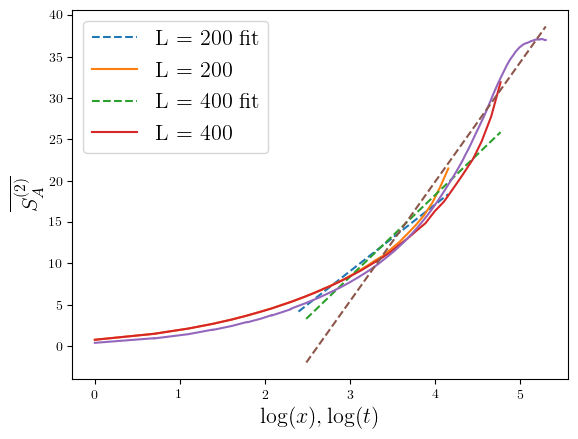

In [7]:
def fig2(filenames, timeseries_filenames):
	linear_fit = True
	ax = plt.gca()
	data = []
	for filename in filenames:
		data.append(load_data(filename))
	
	xs = {}
	Ss = {}
	for df in data:
		xs[df.slides[0].get('system_size')] = []
		Ss[df.slides[0].get('system_size')] = []
		for slide in df.slides:
			xs[slide.get('system_size')].append(slide.get('partition_size'))
			Ss[slide.get('system_size')].append(np.mean(slide.get('entropy')))
		xs[df.slides[0].get('system_size')] = np.array(xs[df.slides[0].get('system_size')])
		Ss[df.slides[0].get('system_size')] = np.array(Ss[df.slides[0].get('system_size')])
	
	for L, LA in xs.items():
		xs[L] = logx(LA, L)

	for L, x in xs.items():
		inds = np.argsort(xs[L])
		xs[L] = xs[L][inds]
		Ss[L] = Ss[L][inds]

		if linear_fit:
			fit_ind = 10
			p = curve_fit(linear, xs[L][fit_ind:], Ss[L][fit_ind:])[0]
			plt.plot(xs[L][fit_ind:], p[0]*xs[L][fit_ind:] + p[1], linestyle='--', label=f'L = {L} fit')
			print(f'{L}: {p}')
		plt.plot(xs[L], Ss[L], label=f'L = {L}')


	time = timeseries_filenames != []
	xlabel = r'$\log(x), \log(t)$' if time else r'$\log(x)$'
	ax.set_xlabel(xlabel, fontsize=16)

	ax.set_ylabel(ee_string, fontsize=16)
	ax.legend(fontsize=16)
	if time:
		data = [average_data(load_data(f)) for f in timeseries_filenames]

		S, dS, N, t = [np.concatenate(tuple(val[i] for val in data)) for i in range(4)]

		inds = np.argsort(t)
		S, dS, N, t = S[inds], dS[inds], N[inds], t[inds]
		
		logt = np.log(t)

		ax.plot(logt, S)
		if linear_fit:
			fit_ind = 15
			p = curve_fit(linear, logt[fit_ind:], S[fit_ind:])[0]
			ax.plot(logt[fit_ind:], p[0]*logt[fit_ind:] + p[1], linestyle='--')
			print(f'800 logt: {list(p)}')
	
	plt.show()
	
filenames = ['data/fig2_1.json', 'data/fig2_2.json']
timeseries_filenames = ['data/timeseries.json', 'data/timeseries_small.json']
fig2(filenames, timeseries_filenames)

filenames = ['data/fig2_1' + suffix2 + '.json', 'data/fig2_2' + suffix2 + '.json']
timeseries_filenames = ['data/timeseries' + suffix2 + '.json', 'data/timeseries_small' + suffix2 + '.json']
fig2(filenames, timeseries_filenames)

filenames = ['data/fig2_1' + suffix4 + '.json', 'data/fig2_2' + suffix4 + '.json']
timeseries_filenames = ['data/timeseries' + suffix4 + '.json', 'data/timeseries_small' + suffix4 + '.json']
fig2(filenames, timeseries_filenames)

800 logt: [1.1031325035395005, -0.3771114170744021]
800 logt: [2.516354759529199, -1.4972183957506218]


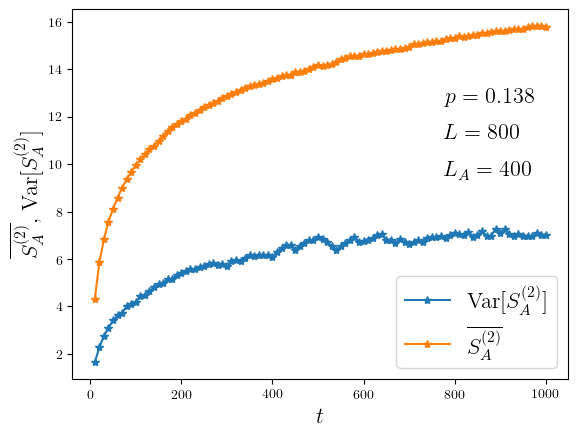

800 logt: [1.314178531447715, -2.033219645699525]
800 logt: [1.6650571096603157, -1.9344662646698718]


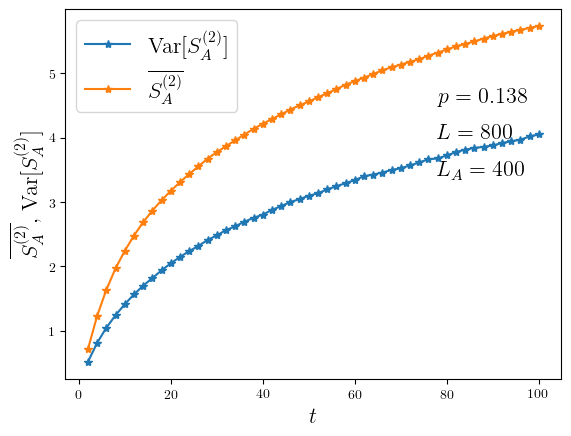

800 logt: [4.685621232692827, -8.170996963786761]
800 logt: [16.6882509236839, -48.584693373038355]


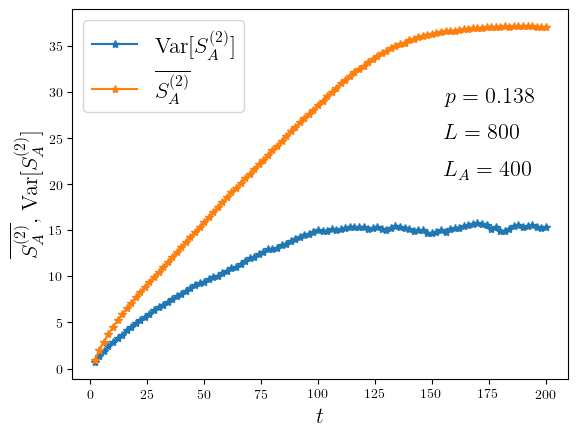

In [8]:
def fig3(filename):
	ax = plt.gca()
	data = load_data(filename)
	S, dS, N, t = average_data(data)
	logt = np.log(t)
	var = dS**2

	L = data.get('system_size')[0]

	ax.plot(t, var, marker='*', label=ee_var_string)
	ax.plot(t, S, marker='*', label=ee_string)
	ax.text(0.75, 0.75, r'$p = 0.138$', transform=ax.transAxes, fontsize=16)
	ax.text(0.75, 0.65, r'$L = 800$', transform=ax.transAxes, fontsize=16)
	ax.text(0.75, 0.55, r'$L_A = 400$', transform=ax.transAxes, fontsize=16)
	ax.set_xlabel(r'$t$', fontsize=16)
	ax.set_ylabel(ee_string + ", " + ee_var_string, fontsize=16)
	ax.legend(fontsize=16)

	fit_ind = 15
	p = curve_fit(linear, logt[fit_ind:], var[fit_ind:])[0]
	print(f'800 logt: {list(p)}')

	fit_ind = 15
	p = curve_fit(linear, logt[fit_ind:], S[fit_ind:])[0]
	print(f'800 logt: {list(p)}')
	plt.show()

fig3('data/timeseries.json')
fig3('data/timeseries' + suffix2 + '.json')
fig3('data/timeseries' + suffix4 + '.json')

S: [4.391462734824113, -5.123244505574793]
var: [0.5479613751100862, 0.05584814324344019]


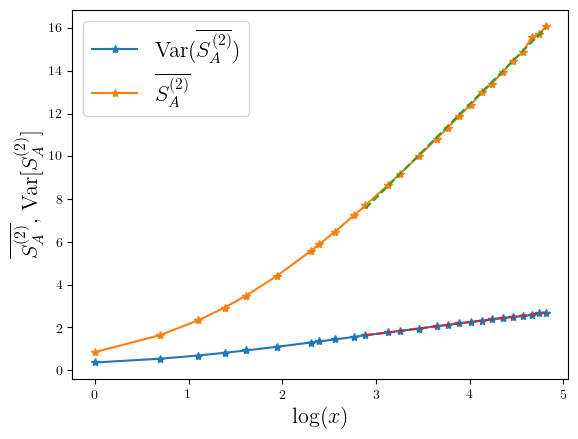

S: [1.85347982932085, -1.0591537836365357]
var: [0.37459771835278916, 0.5806816072747374]


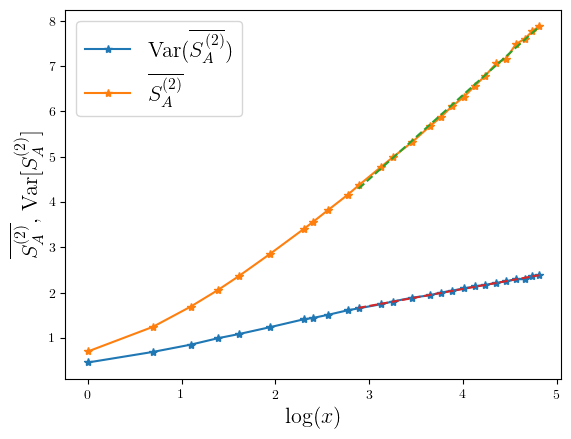

S: [12.695492149520419, -32.29773541383266]
var: [1.120146318317999, -1.25655051219822]


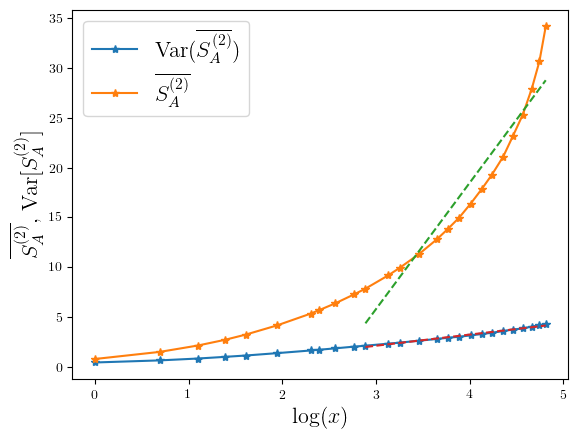

In [5]:
def fig4(filename):
	data = load_data(filename)

	partition_sizes, entropy, entropy_err = combine_slides(data)
	entropy_var = entropy_err**2
	system_size = data.get('system_size')[0]


	x = np.array([logx(partition_size, system_size) for partition_size in partition_sizes])
	x, entropy, entropy_var = truncate_data(x, entropy, entropy_err)

	ax = plt.gca()
	ax.plot(x, entropy_var, marker='*', label=f'Var({ee_string})')
	ax.plot(x, entropy, marker='*', label=ee_string)
	ax.set_xlabel(r'$\log(x)$', fontsize=16)
	ax.set_ylabel(ee_string + ", " + ee_var_string, fontsize=16)
	ax.legend(fontsize=16)

	fit_ind = 10
	p = curve_fit(linear, x[fit_ind:], entropy[fit_ind:])[0]
	ax.plot(x[fit_ind:], p[0]*x[fit_ind:] + p[1], linestyle='--')
	print(f'S: {list(p)}')

	p = curve_fit(linear, x[fit_ind:], entropy_var[fit_ind:])[0]
	ax.plot(x[fit_ind:], p[0]*x[fit_ind:] + p[1], linestyle='--')
	print(f'var: {list(p)}')

	plt.show()

fig4('data/fluctuations.json')
fig4('data/fluctuations' + suffix2 + '.json')
fig4('data/fluctuations' + suffix4 + '.json')


var: [4.022308848194989e-05, 1.906154775198471]


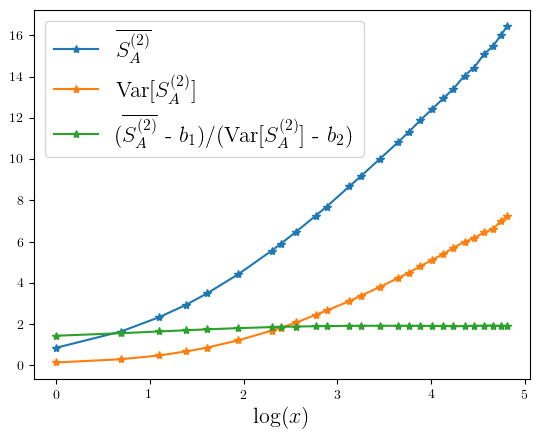

var: [1.2721065199006176e-05, 1.2145155627696744]


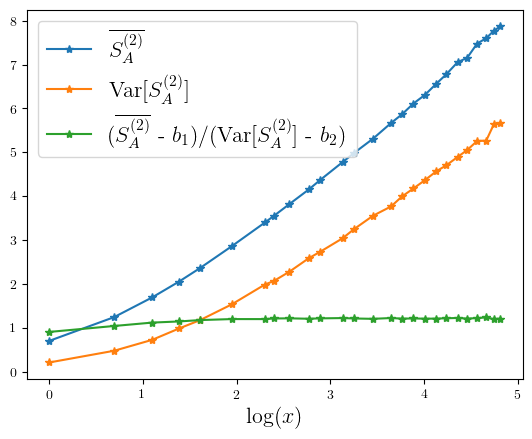

In [10]:
def fig5(filename):
	data = load_data(filename)

	partition_sizes, entropy, entropy_err = combine_slides(data)
	entropy_var = entropy_err**2
	system_size = data.get('system_size')[0]


	x = np.array([logx(partition_size, system_size) for partition_size in partition_sizes])
	x, entropy, entropy_var = truncate_data(x, entropy, entropy_var)
	fig, ax = plt.subplots()

	plt.plot(x, entropy, label=ee_string, marker='*')
	plt.plot(x, entropy_var, label=ee_var_string, marker='*')
	plt.xlabel(r'$\log(x)$', fontsize=16)

	fit_ind = 10
	p1 = curve_fit(linear, x[fit_ind:], entropy[fit_ind:])[0]
	p2 = curve_fit(linear, x[fit_ind:], entropy_var[fit_ind:])[0]

	r = (entropy - p1[1])/(entropy_var - p2[1])
	plt.plot(x, r, label = "(" + ee_string + r" - $b_1$)/(" + ee_var_string + r" - $b_2$)", marker='*')

	p = curve_fit(linear, x[fit_ind:], r[fit_ind:])[0]
	#ax.plot(x[fit_ind:], p[0]*x[fit_ind:] + p[1], linestyle='--')
	print(f'var: {list(p)}')

	plt.legend(fontsize=16)
	plt.show()

fig5('data/fluctuations.json')
fig5('data/fluctuations' + suffix2 + '.json')

CXCZ Circuit:


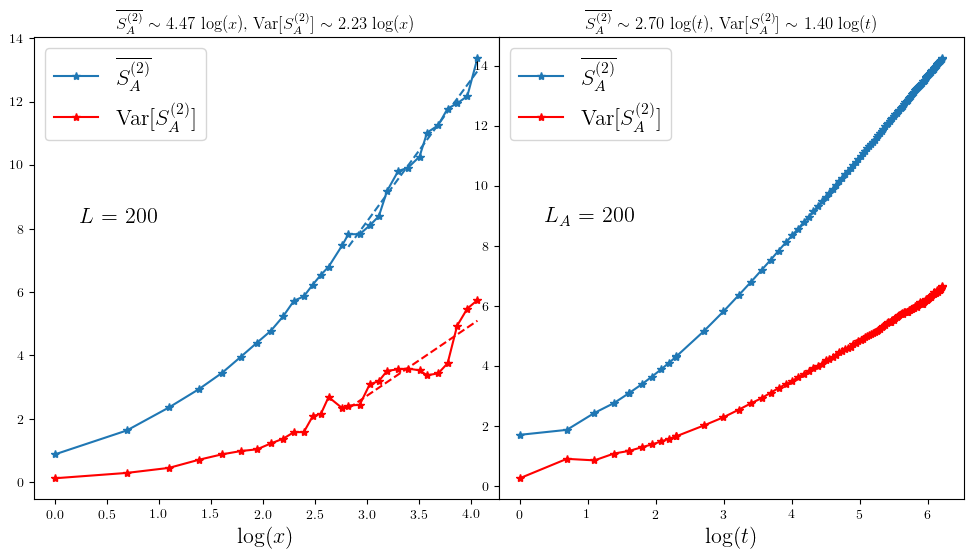

In [10]:
def get_coefficients(timeseries_filenames, fluctuation_filename):
	data_fluc = load_data(fluctuation_filename)

	partition_sizes, entropy, entropy_err = combine_slides(data_fluc)
	entropy_var = entropy_err**2

	system_size = data_fluc.get('system_size')[0]

	x = np.array([logx(partition_size, system_size) for partition_size in partition_sizes])
	x, entropy, entropy_var = truncate_data(x, entropy, entropy_var)

	
	partition_sizes2, entropy2, entropy_err2 = combine_slides(load_data("data/fluctuations2_small.json"))
	entropy_var2 = entropy_err2**2
	x2 = np.array([logx(partition_size, system_size) for partition_size in partition_sizes2])
	x2, entropy2, entropy_var2 = truncate_data(x2, entropy2, entropy_var2)

	fit_ind = 15
	a_entropy, y_entropy = curve_fit(linear, x[fit_ind:], entropy[fit_ind:])[0]
	a_entropy_var, y_entropy_var = curve_fit(linear, x[fit_ind:], entropy_var[fit_ind:])[0]

	fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
	ax[0].plot(x, entropy, color='C0', label=ee_string, marker='*')
	#ax[0].plot(x2, entropy2)
	#ax[0].plot(x2, entropy_var2)
	ax[0].plot(x[fit_ind:], a_entropy*x[fit_ind:] + y_entropy, color='C0', linestyle='--')
	ax[0].plot(x, entropy_var, color='red', label=ee_var_string, marker='*')
	ax[0].plot(x[fit_ind:], a_entropy_var*x[fit_ind:] + y_entropy_var, color='red', linestyle='--')
	ax[0].set_title(ee_string + r' $\sim$ ' + f'{a_entropy:.2f}' + r' $\log(x)$, ' + ee_var_string + r' $\sim$ ' + f'{a_entropy_var:.2f}' + r' $\log(x)$', )
	ax[0].set_xlabel(r'$\log(x)$', fontsize=16)
	ax[0].text(0.1, 0.6, r"$L$" + f" = {data_fluc.get('system_size')[0]}", transform=ax[0].transAxes, fontsize=16)
	ax[0].legend(fontsize=16)

	data = [average_data(load_data(f)) for f in timeseries_filenames]

	fit_ind = 20
	entropy, entropy_err, N, t = [np.concatenate(tuple(val[i] for val in data)) for i in range(4)]
	inds = np.argsort(t)
	entropy, entropy_var, N, t = entropy[inds], entropy_err[inds]**2, N[inds], t[inds]
	logt = np.log(t)

	a_entropy, y_entropy = curve_fit(linear, logt[fit_ind:], entropy[fit_ind:])[0]
	a_entropy_var, y_entropy_var = curve_fit(linear, logt[fit_ind:], entropy_var[fit_ind:])[0]

	ax[1].plot(logt, entropy, color='C0', label=ee_string, marker='*')
	ax[1].plot(logt[fit_ind:], a_entropy*logt[fit_ind:] + y_entropy, color='C0', linestyle='--')
	ax[1].plot(logt, entropy_var, color='red', label=ee_var_string, marker='*')
	ax[1].plot(logt[fit_ind:], a_entropy_var*logt[fit_ind:] + y_entropy_var, color='red', linestyle='--')
	ax[1].set_title(ee_string + r' $\sim$ ' + f'{a_entropy:.2f}' + r' $\log(t)$, ' + ee_var_string + r' $\sim$ ' + f'{a_entropy_var:.2f}' + r' $\log(t)$', )
	ax[1].set_xlabel(r'$\log(t)$', fontsize=16)
	ax[1].text(0.1, 0.6, r"$L_A$" + f" = {load_data(timeseries_filenames[0]).get('partition_size')[0]}", transform=ax[1].transAxes, fontsize=16)
	ax[1].legend(fontsize=16)

	plt.subplots_adjust(wspace=0)
	plt.show()

print("CXCZ Circuit:")
get_coefficients(["data/timeseries.json", "data/timeseries_small.json"], "data/fluctuations_small.json")
#print("Random Clifford (2) Circuit:")
#get_coefficients(["data/timeseries" + suffix2 + ".json", "data/timeseries_small" + suffix2 + ".json"], "data/fluctuations" + suffix2 + ".json")
#print("Random Clifford (4) Circuit:")
#get_coefficients(["data/timeseries" + suffix4 + ".json", "data/timeseries_small" + suffix4 + ".json"], "data/fluctuations" + suffix4 + ".json")

	